# **Required Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Utility
import os
from tqdm import tqdm 
import random
import scipy
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Computer vision
import cv2
from skimage.feature import hog
# Data science
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
import optuna
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, matthews_corrcoef, precision_score, \
    balanced_accuracy_score, f1_score, recall_score,fbeta_score,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Consider aesthetics 
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 16})
print("Libraries imported")

Libraries imported


We also create a `figure` folder to save figures produced

In [2]:
if os.path.isdir("/kaggle/working/figures"):
    pass
else:
    os.mkdir("/kaggle/working/figures")

# **Notebook outline**

**In this notebook, our objectives are as follows:**
1. Load the grayscale dataset perform preprocessing & feature extraction as needed.
1. Utilize classical ML algorithms to predict the fungi classes from these features

---

# **Classical ML**

We utilize the grayscale dataset as it simplifies the learning process for classical machine learning algorithms, making it easier for them to identify patterns and relationships within the data.

## *1. Dataset split*

In [22]:
df_gray = pd.read_hdf("/kaggle/input/fungi-final-dataset/gray_data.h5")

We employ a stratified split to partition the data into training and testing datasets, ensuring an equal distribution of class counts. To validate our approach, we display the shapes of the training and testing sets, along with the percentage of class labels in each of them.

In [4]:
X = df_gray['images'].values
y = df_gray['labels'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_temp, X_test, y_temp, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the shapes of the sets
print(f"The shape of the training set is: {X_train.shape}")
print(f"The shape of the validation set is: {X_val.shape}")
print(f"The shape of the test set is: {X_test.shape}")

sets = {"Training": y_train, "Validation": y_val, "Test": y_test}

# Loop through the sets and print class distributions
for key, value in sets.items():
    unique_classes = np.unique(value)
    class_counts = pd.Series(value).value_counts().sort_index()
    print(f"\nClass distribution in {key} set:")
    for class_label, count in zip(unique_classes, class_counts):
        print(f"Class {class_label}: {round((count / sum(class_counts) * 100), 2)}% of total samples")

The shape of the training set is: (4760,)
The shape of the validation set is: (510,)
The shape of the test set is: (510,)

Class distribution in Training set:
Class 0: 27.56% of total samples
Class 1: 21.53% of total samples
Class 2: 17.1% of total samples
Class 3: 17.06% of total samples
Class 4: 16.74% of total samples

Class distribution in Validation set:
Class 0: 27.45% of total samples
Class 1: 21.57% of total samples
Class 2: 17.06% of total samples
Class 3: 17.06% of total samples
Class 4: 16.86% of total samples

Class distribution in Test set:
Class 0: 27.65% of total samples
Class 1: 21.57% of total samples
Class 2: 17.06% of total samples
Class 3: 17.06% of total samples
Class 4: 16.67% of total samples


---

## *2. Preprocessing*

In contrast to Neural Networks, which can leverege Convolutional layers to effectively extract  features from data, traditional Machine Learning (ML) algorithms do not benefit from data augmentation techniques, such as rotation & contrast adjusting.  For this reason we utilize preprocessing steps that aim to expose fundamental differences in the imeages based on pixel intensity. Thus we perform:
- Histogram equalization since images have different contrast (contrast consistency)
- Extraction of HOG features (feature selection)
- Normalization (feature scaling)
- PCA

### 2.1 Histogram equalization

In [6]:
# For the training set 
X_train_eq = [cv2.equalizeHist(image) for image in X_train]
# For the test set
X_test_eq = [cv2.equalizeHist(image) for image in X_test]
# For the validation set 
X_val_eq = [cv2.equalizeHist(image) for image in X_val]

Example image before and after equalization:

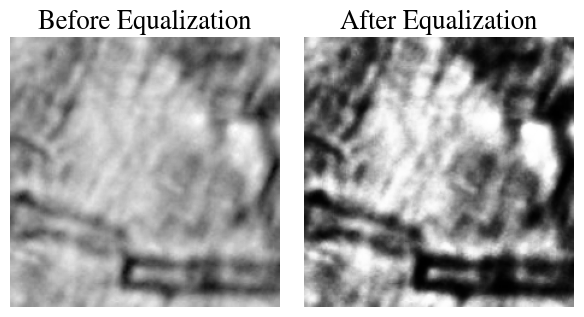

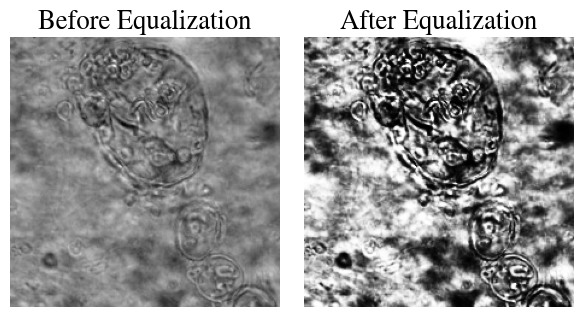

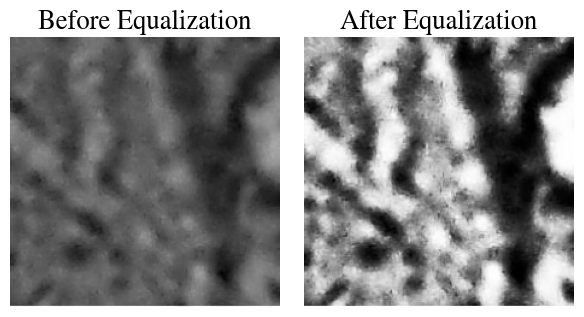

In [7]:
for index in range(0,30,10):
    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 4, 1)
    plt.imshow(X_train[index],cmap ='gray')
    plt.title('Βefore Equalization')
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(X_train_eq[index],cmap ='gray')
    plt.title('After Equalization')
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(f'./figures/example_images_{index}.png', dpi=300) 
    plt.show()

## 2.2 Extraction of Histogram of Oriented Gradients (HOG) features
HOG works by dividing the image into cells and analyzing the distribution of gradient orientations within each cell. The gradients are calculated to measure the changes in pixel intensities, and histograms are constructed to represent the distribution of edge directions. The resulting feature vector captures local shape and edge information, making it useful for classification.

In [8]:
X_train_hog = [hog(image,visualize= False) for image in X_train_eq]
X_test_hog = [hog(image,visualize= False) for image in X_test_eq]
X_val_hog = [hog(image,visualize= False) for image in X_val_eq]

HoG features showcase:

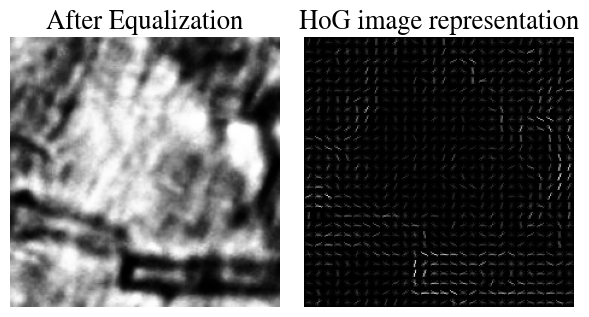

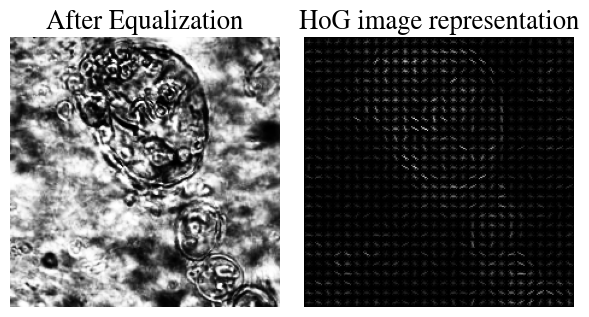

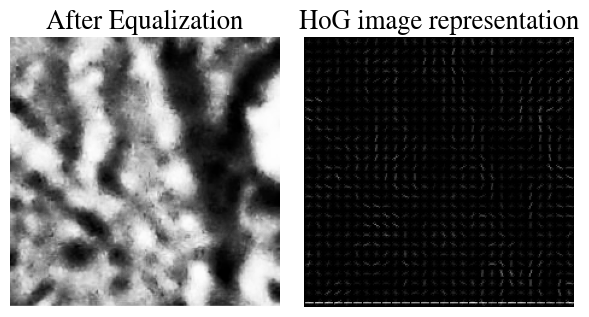

In [9]:
for index in range(0,30,10):
    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 4, 1)
    plt.imshow(X_train_eq[index],cmap ='gray')
    plt.title('After Equalization')
    plt.axis("off")

    plt.subplot(1, 4, 2)
    _, img = hog(X_train[index],visualize= True)
    plt.imshow(img,cmap ='gray')
    plt.title("HoG image representation")
    plt.axis("off")


    plt.tight_layout()
    plt.savefig(f'./figures/example_images_hog_{index}.png', dpi=300) 
    plt.show()

## 2.3 Standardization

Finally we perform standardization

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_hog)
X_test = scaler.transform(X_test_hog)
X_val = scaler.transform(X_val_hog)

In [11]:
print(f"Final training set shape: {X_train.shape}")
print(f"Final test set shape: {X_test.shape}")
print(f"Final validation set shape: {X_val.shape}")

Final training set shape: (4760, 54756)
Final test set shape: (510, 54756)
Final validation set shape: (510, 54756)


---

## 3. *Classifier creation*

We create a function to score our predictions with different metrics and plot them.

- The  Matthews correlation coefficient (MCC) as explained in the beginning is a balanced metric, adjusted for chance(-1,1 value range)
- F1 is the harmonic mean of Precision and Recall
- Since this is an inbalanced problem accuracy is a very bad metric to use in this context since it measures label matching between true and predicted values, we use it just for comparrison. 
- On the other hand balanced accuracy is defined as the average of recall obtained on each class adjusted for chance.

**Thus the two most important metrics to focus on is balanced accuracy and MCC**

In [35]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    matthews_corrcoef,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
)

def score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    
    # Plot cm
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # REsult dict
    scores_dict = {
        "MCC": mcc,
        "F1-Score": f1,
        "Balanced Accuracy": balanced_acc,
        "Accuracy": acc,
    }
    
    # Plot the scores
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(scores_dict.values()), y=list(scores_dict.keys()), palette="viridis")
    plt.xticks(np.arange(0.0,1.1,0.1))
    plt.xlabel('Score')
    plt.ylabel('Metric')
    plt.title('Classification Metrics')
    plt.show()

    return scores_dict

---

### 3.1 **Naive Bayes Baseline Classifier (Non-linear Classifier, Feature Independence Assumption)**

Since the GNB classifier does not require tuning, we can use it as  a baseline classifier to compare it to others.

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       141
           1       0.35      0.17      0.23       110
           2       0.25      0.18      0.21        87
           3       0.43      0.52      0.47        87
           4       0.32      0.49      0.39        85

    accuracy                           0.42       510
   macro avg       0.39      0.40      0.38       510
weighted avg       0.41      0.42      0.40       510



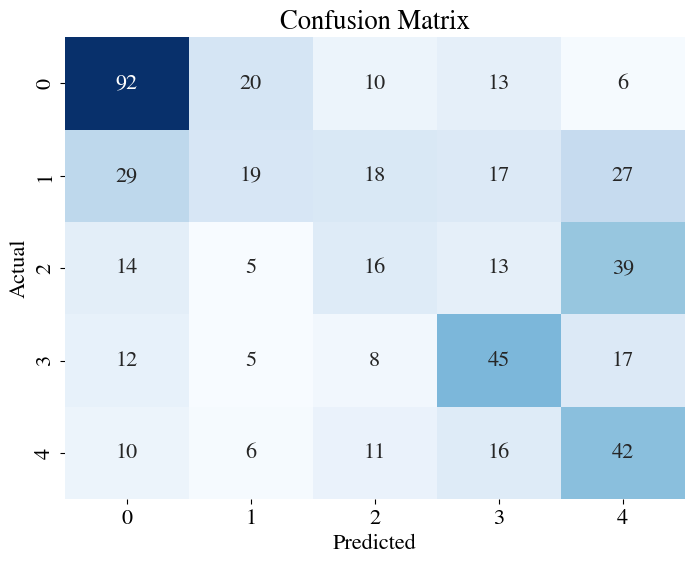

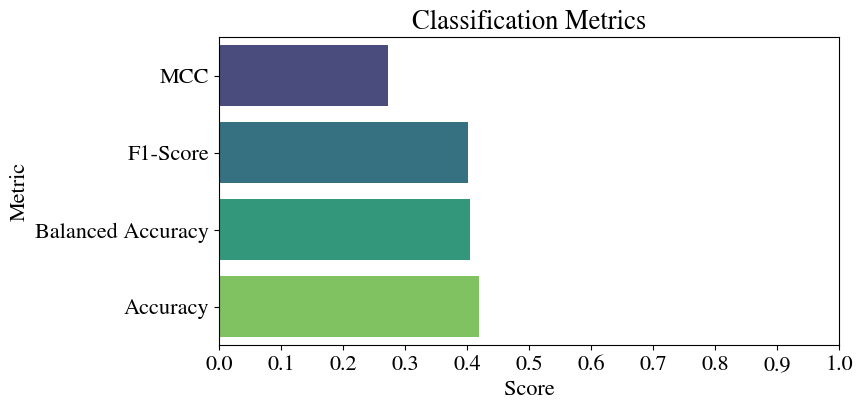

In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
gnd_scores = score(y_test,y_pred)

---

### 3.2 **Logistic Regression classifier (Linear Classifier + softmax)** 

Logistic regression is a linear classification model that allows for regularization via:
- C: Which correponds to the inverse  of regularization strength in logistic regression, controlling the amount of regularization applied via multiplying the value of C with the norm of the coefficients. Smaller values indicate stronger regularization.


In [37]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import optuna

def objective(trial):
    C = trial.suggest_float('C', 0.001, 100.0, log=True)
    lr = LogisticRegression(C=C, solver='lbfgs', multi_class='multinomial', random_state=42, class_weight='balanced')

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    mcc = matthews_corrcoef(y_val, y_pred)

    return mcc

sampler = optuna.samplers.TPESampler(multivariate=False, seed=42)
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=10, show_progress_bar=True, n_jobs=-1)
best_params = study.best_params
best_mcc = study.best_value

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
print(study.best_params)

{'C': 0.27283563645708253}


              precision    recall  f1-score   support

           0       0.48      0.48      0.48       141
           1       0.16      0.15      0.15       110
           2       0.24      0.30      0.26        87
           3       0.41      0.34      0.38        87
           4       0.31      0.33      0.32        85

    accuracy                           0.33       510
   macro avg       0.32      0.32      0.32       510
weighted avg       0.33      0.33      0.33       510



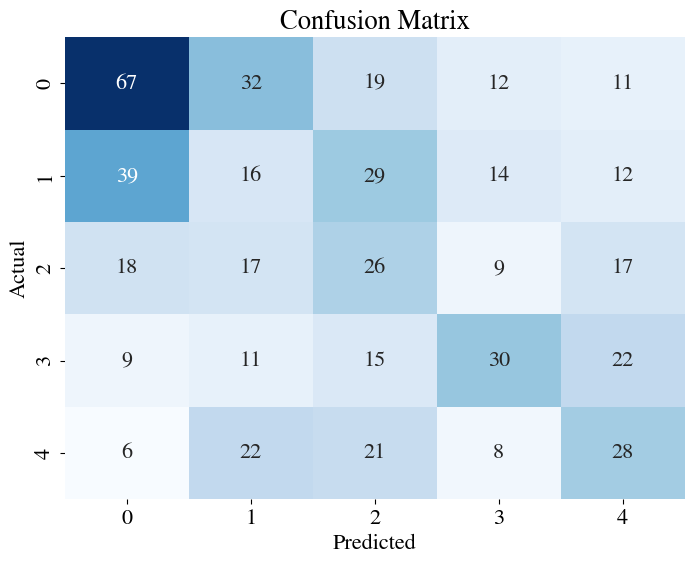

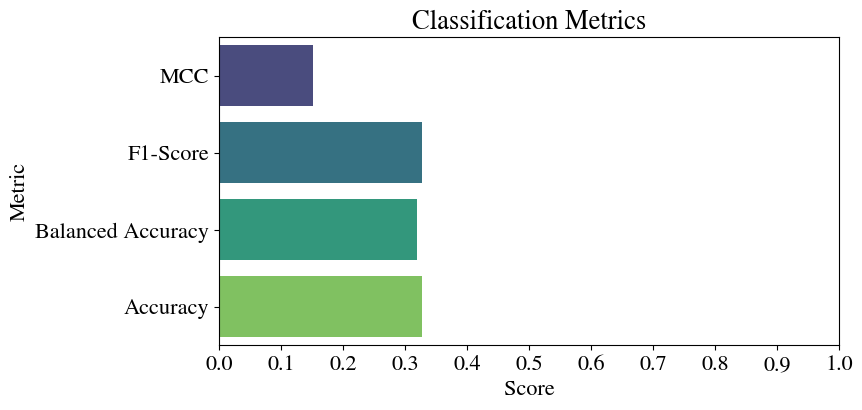

In [39]:
lr = LogisticRegression(C=best_params['C'], solver='lbfgs', multi_class='multinomial', random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_scores = score(y_test,y_pred)

---

### 3.3 **Decision Tree classifier (Νon-linear classifier)**

In [40]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500, log=True)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    # Create a Random Forest classifier with the suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1,  # Utilize all CPU cores
        class_weight='balanced'
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mcc = matthews_corrcoef(y_val, y_pred)

    return mcc

sampler = optuna.samplers.TPESampler(multivariate=True, seed=42)
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)  # Adjust n_jobs as needed
best_params = study.best_params
best_mcc = study.best_value

  0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.48      0.74      0.58       141
           1       0.36      0.04      0.07       110
           2       0.33      0.07      0.11        87
           3       0.33      0.32      0.32        87
           4       0.25      0.53      0.34        85

    accuracy                           0.37       510
   macro avg       0.35      0.34      0.29       510
weighted avg       0.37      0.37      0.31       510



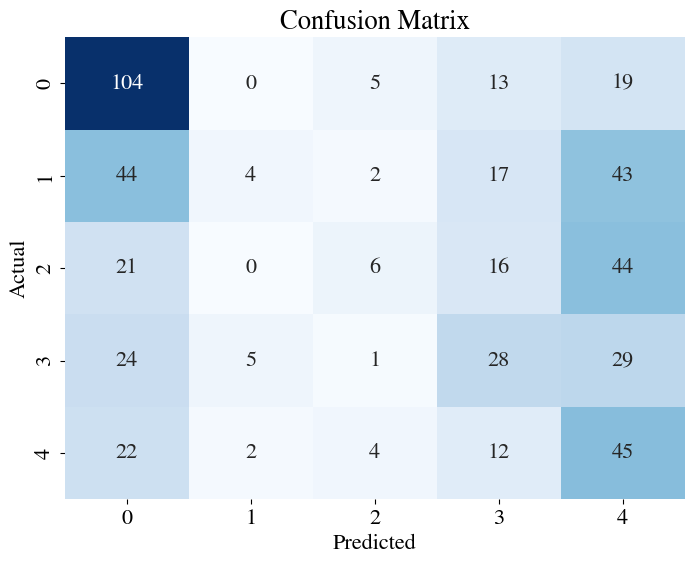

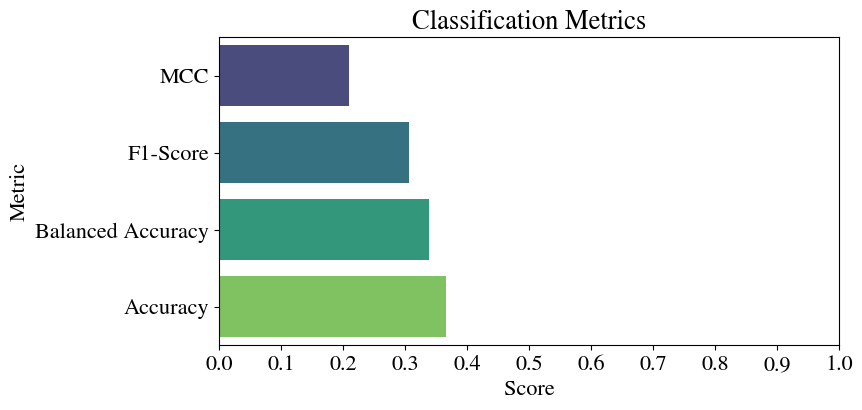

In [41]:
rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_scores = score(y_test,y_pred)

---

# **4. Reducing the Dimensions with PCA and re-training**

## PCA

In [12]:
X_train.shape

(4760, 54756)

In [13]:
pca = PCA(n_components = X_train.shape[0])
X_train_pc = pca.fit_transform(X_train)
X_val_pc = pca.transform(X_val)
X_test_pc = pca.transform(X_test)

### Classifier re-training

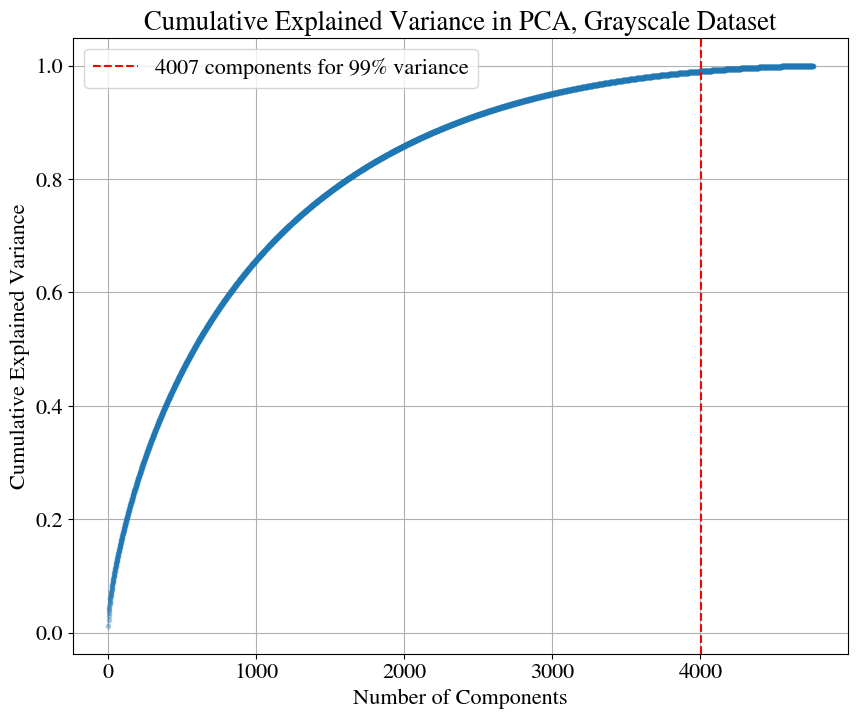

In [20]:
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_explained_variance >= 0.99) + 1

plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='.', alpha = 0.3)
plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} components for 99% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance in PCA, Grayscale Dataset')
plt.legend()
plt.grid(True)
plt.savefig('./figures/explained_var_gray.png', dpi=300) 
plt.show()

In [27]:
X_train = X_train_pc[:,:4007]
X_test = X_test_pc[:,:4007]
X_val = X_val_pc[:,:4007]

---

## 4.1 Naive Bayes CLassifier

              precision    recall  f1-score   support

           0       0.29      1.00      0.44       141
           1       0.00      0.00      0.00       110
           2       0.75      0.03      0.07        87
           3       0.67      0.02      0.04        87
           4       1.00      0.09      0.17        85

    accuracy                           0.30       510
   macro avg       0.54      0.23      0.15       510
weighted avg       0.49      0.30      0.17       510



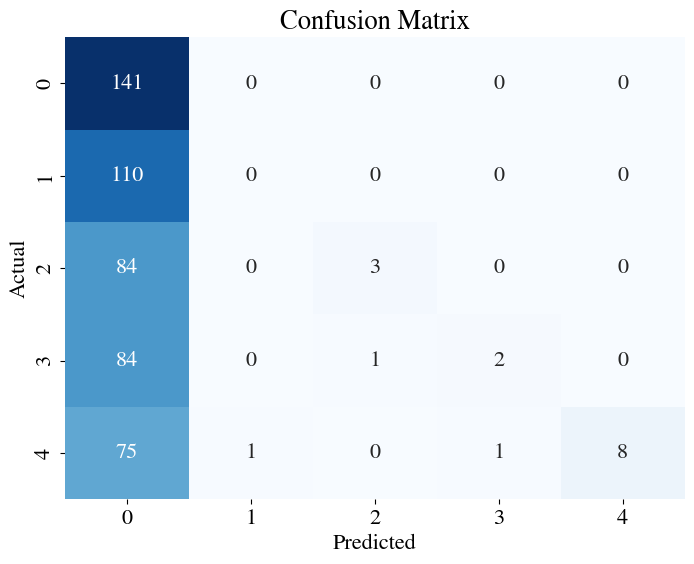

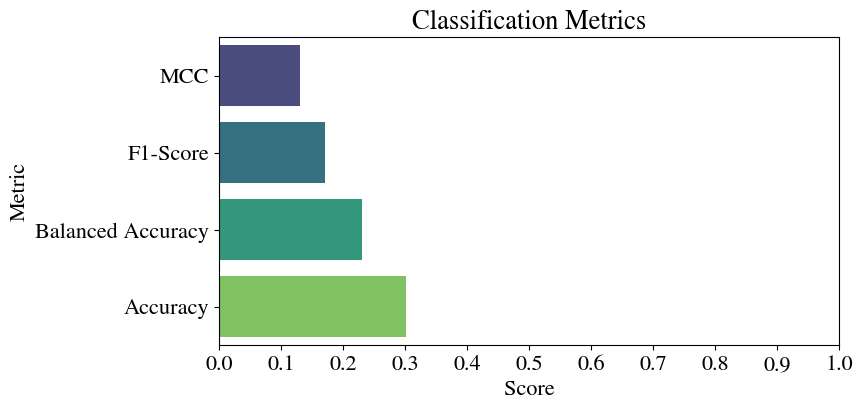

In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
gnd_scores = score(y_test,y_pred)

---

### 4.2 Logistic Regression Classifier

In [30]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import optuna

def objective(trial):
    C = trial.suggest_float('C', 0.001, 100.0, log=True)
    lr = LogisticRegression(C=C, solver='lbfgs', multi_class='multinomial', random_state=42, class_weight='balanced')

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    mcc = matthews_corrcoef(y_val, y_pred)

    return mcc

sampler = optuna.samplers.TPESampler(multivariate=False, seed=42)
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=10, show_progress_bar=True, n_jobs=-1)
best_params = study.best_params
best_mcc = study.best_value

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       141
           1       0.24      0.21      0.22       110
           2       0.24      0.30      0.27        87
           3       0.41      0.38      0.40        87
           4       0.31      0.33      0.32        85

    accuracy                           0.35       510
   macro avg       0.34      0.34      0.34       510
weighted avg       0.36      0.35      0.35       510



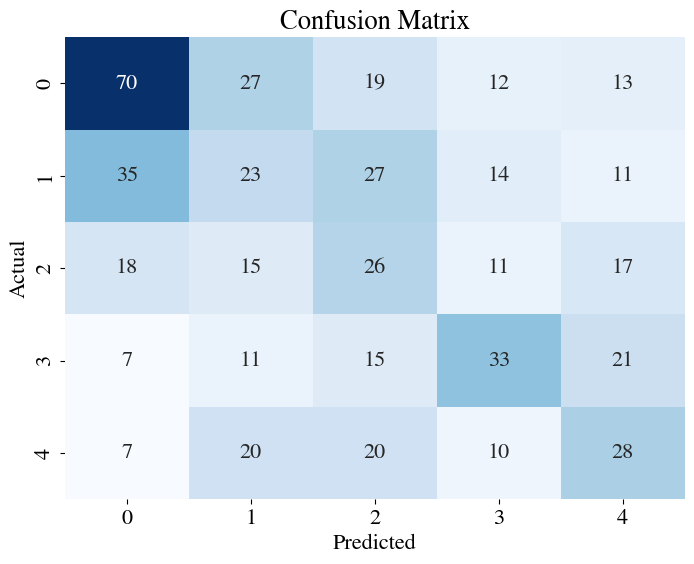

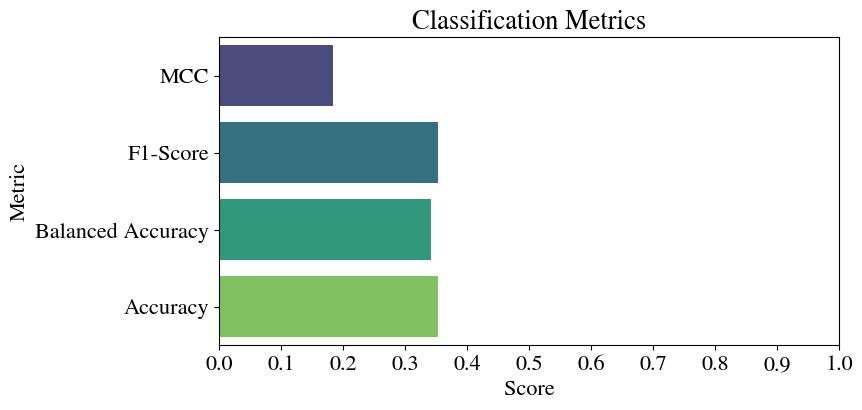

In [31]:
lr = LogisticRegression(C=best_params['C'], solver='lbfgs', multi_class='multinomial', random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_scores = score(y_test,y_pred)

---

### 4.3 **Random Forest Decision Tree classifier re-training**

In [28]:
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500, log=True)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    
    # Create a Random Forest classifier with the suggested hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1,  # Utilize all CPU cores
        class_weight='balanced'
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mcc = matthews_corrcoef(y_val, y_pred)

    return mcc

sampler = optuna.samplers.TPESampler(multivariate=True, seed=42)
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=-1)  # Adjust n_jobs as needed
best_params = study.best_params
best_mcc = study.best_value

  0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.49      0.80      0.61       141
           1       0.24      0.07      0.11       110
           2       0.51      0.31      0.39        87
           3       0.36      0.62      0.46        87
           4       0.51      0.26      0.34        85

    accuracy                           0.44       510
   macro avg       0.42      0.41      0.38       510
weighted avg       0.42      0.44      0.39       510



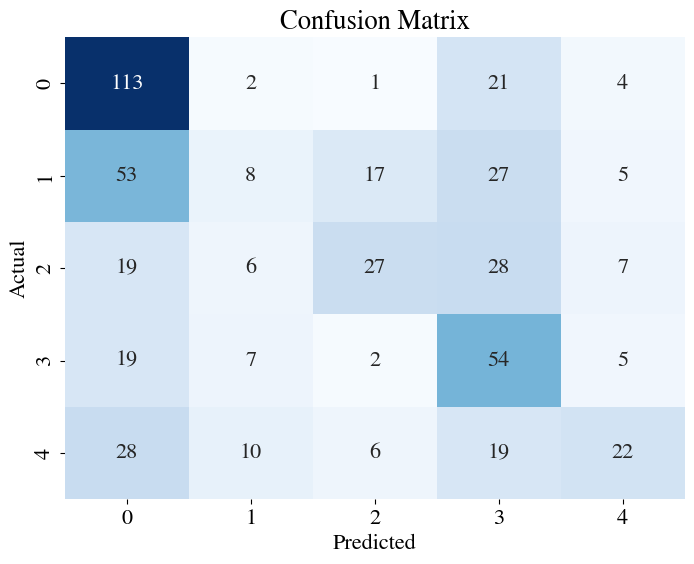

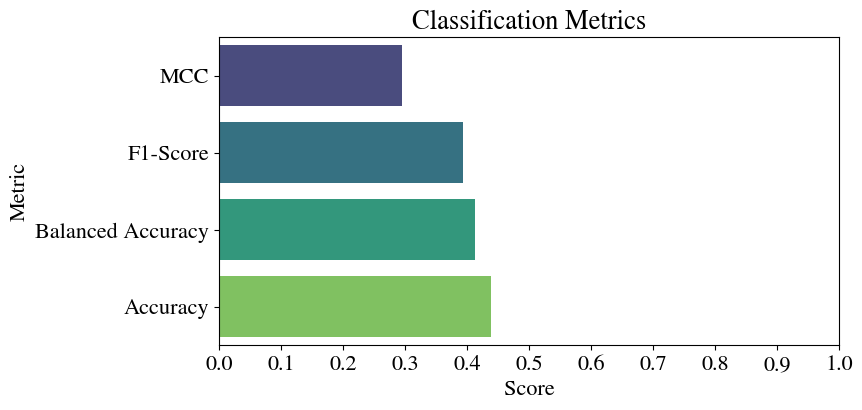

In [29]:
rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf_scores = score(y_test,y_pred)

---